<a href="https://colab.research.google.com/github/sagorbrur/bangla-bert/blob/master/notebook/bangla_bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bangla-BERT-Base

In [609]:
# papers to look into
# https://www.researchgate.net/publication/378998697_Methods_and_Annotated_Data_Sets_Used_to_Predict_the_Gender_and_Age_of_Twitter_Users_Scoping_Review
# https://www.researchgate.net/publication/366079977_Scoping_Review_of_Methods_and_Annotated_Datasets_Used_to_Predict_Gender_and_Age_of_Twitter_Users

## Bangla BERT Tokenization

In [2]:
import pandas as pd
dataset_url = 'https://raw.githubusercontent.com/supreme-lab/gender-identification/main/dataset.csv'

df = pd.read_csv(dataset_url)
df = df.dropna(subset=['text', 'gender'])
df.head()

,text,gender
0,ল্যাবে গ্রুপমেটের গ্রাফ নিজে একে দিয়েছি অনেক ...,M
1,"এরকম এক রমজান মাসের স্নিগ্ধ বিকেলে, জনৈক বুয়েট...",M
2,শিবিরবিহীন বুয়েট থেকে শিবিরের কেন্দ্রীয় কমিটির...,M
3,জনৈক বন্ধু তার বান্ধবীর সাথে দেখা করার আগে নিজ...,M
4,খুব ক্লোজ জুনিয়রের সাথে শেরে বাংলা হলের সামনের...,M


In [3]:
df.index.size

15367

In [4]:
def get_male_female_keywords(posts, genders):
  # compute keyword for male and female samples
  male_keywords = []
  female_keywords = []
  for idx, post in enumerate(posts):
    splitted = post.split()
    if genders[idx] == "M":
      male_keywords.extend(splitted)
    else:
      female_keywords.extend(splitted)
  return male_keywords, female_keywords

In [5]:
def get_frequency_from_list(keywords):
  freq = {}
  for word in keywords:
    if word in freq:
      freq[word] = freq[word] + 1
    else:
      freq[word] = 1
  return freq

In [6]:
import numpy as np
import pathlib
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.linear_model import SGDClassifier
import random
from sklearn.feature_selection import SelectKBest, chi2

class DataPreProcessor(object):
  def __init__(self, dataset_url):
    self.dataset_url = dataset_url

  def preprocess(self):
    # stop word list
    stop_word_file = 'https://raw.githubusercontent.com/supreme-lab/gender-identification/main/stopwords-bn.txt'
    sw_df = pd.read_csv(stop_word_file, delimiter="\t", header=None)
    stopword_list = sw_df.values.tolist()

    # load the training data
    df = pd.read_csv(self.dataset_url)

    # preprocess step 0: remove duplicate rows
    df = df.drop_duplicates()
    print("after removing duplicate rows, row count: ", df.index.size)

    # preprocess step 1: remove null rows
    df = df.dropna(subset=['text', 'gender'])
    print("after removing null rows, row count: ", df.index.size)
    
    ## TODO remove images, hashtags, links, user tags

    # preprocess step 2: remove non Bangla characters
    author_posts = []
    author_genders = []
    for index, row in df.iterrows():
        tokens = [re.sub(r'[^\u0980-\u09FF ]+', ' ', str(row['text']))]
        tokens_joined = " ".join(tokens)
        if len(tokens_joined) == 0:
          print("tokens_joined.len==0")
        author_posts.append(tokens_joined)
        author_genders.append(row['gender'])

    stopword_list_new = []
    for word in stopword_list:
      stopword_list_new.append(word[0])
    stopword_list = stopword_list_new
    
    # preprocess step 3: remove stop words
    author_posts_without_stopword = []
    author_genders_without_stopword = []
    i = 0
    for idx, post in enumerate(author_posts):
        i = i + 1
        # if i< 100:
        #   print("before stopword removal sent.len: ", len(post.split()))
        tokens_without_stopword = [word for word in post.split() if not word in stopword_list]
        # if i<100:
        #   print("after stopword removal sent.len: ", len(tokens_without_stopword))
        tokens_without_stopword_joined = " ".join(tokens_without_stopword)
        if len(tokens_without_stopword_joined) > 0:
          # print("tokens_without_stopword_joined: ", tokens_without_stopword_joined)
          # print("len(tokens_without_stopword_joined) == 0")
          author_posts_without_stopword.append(tokens_without_stopword_joined)
          author_genders_without_stopword.append(author_genders[idx])
    
    # # start - to experiment without removing stopwords 
    # author_posts_without_stopword = author_posts
    # author_genders_without_stopword = author_genders
    # # end - to experiment without removing stopwords 
    
    post_count = len(author_posts_without_stopword)
    gender_count = len(author_genders_without_stopword)

    print(f"after stopword removing posts.len: {post_count}, gender.count: {gender_count}")

    malekeywords, femalekeywords = get_male_female_keywords(author_posts_without_stopword, author_genders)
    
    # compute keyword occurrence in male and female data
    # print("compute keyword occurrence in male and female data")
    male_freq = get_frequency_from_list(malekeywords)
    female_freq = get_frequency_from_list(femalekeywords)

    # filter out keywords with occurrence <10
    # print("filter out keywords with occurrence <10 ")
    
    features = []
    for key, value in male_freq.items():
      if value >= 10:
        features.append(key)

    for key, value in female_freq.items():
      if value >= 10:
        features.append(key)

    # get the unique keywords
    # print("get the unique keywords")
    featureset = set(features)
    # print("featureset.len: ", len(featureset))

    # keep words which are in the featureset
    # print("keep words which are in the featureset")
    i = 0
    author_posts_with_keywords_in_features = []
    author_genders_with_keywords_in_features = []
    for idx, post in enumerate(author_posts_without_stopword):
        # if i < 100:
        #   print("post.len: ", len(post.split()))
        tokens_filtered_with_features = [word for word in post.split() if word in featureset]
        tokens_filtered_with_features_joined = " ".join(tokens_filtered_with_features)
        # if i<100:
        #   print("tokens_without_keywords_with_occurrence1.len: ", len(tokens_without_keywords_with_occurrence1))
        
        if len(tokens_filtered_with_features_joined) > 0:
          # print("len(tokens_filtered_with_features_joined) == 0")
          author_posts_with_keywords_in_features.append(tokens_filtered_with_features_joined)
          author_genders_with_keywords_in_features.append(author_genders_without_stopword[idx])
    
    post_count = len(author_posts_with_keywords_in_features)
    gender_count = len(author_genders_with_keywords_in_features)

    print(f"after removing out of features posts.len: {post_count}, gender.count: {gender_count}")
    print("author_genders_with_keywords_in_features[0:10]: ", author_genders_with_keywords_in_features[0:10])

    return author_posts_with_keywords_in_features, author_genders_with_keywords_in_features, male_freq, female_freq

In [7]:
dataset_url = "https://raw.githubusercontent.com/supreme-lab/gender-identification/main/dataset.csv"
preprocessor = DataPreProcessor(dataset_url)
posts, genders, male_keywords_frequency, female_keywords_frequency = preprocessor.preprocess()

after removing duplicate rows, row count:  12726
after removing null rows, row count:  12726
after stopword removing posts.len: 10544, gender.count: 10544
after removing out of features posts.len: 10397, gender.count: 10397
author_genders_with_keywords_in_features[0:10]:  ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F']


In [8]:
len(posts), len(genders)

(10397, 10397)

In [9]:
genders[0:10]

['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F']

In [10]:
!/usr/bin/python3.9 -m pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


### generate wordcloud

In [619]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(word_counts):

    # Generate word frequencies (you need to implement this step)
    # word_frequencies = {'বাংলা': 1, 'ভাষার': 1, 'ভিত্তি': 1, 'ওয়ার্ড': 1, 'ক্লাউড': 1, 'তৈরি': 1, 'করা': 1}

    # Create the word cloud
    wordcloud = WordCloud(font_path='kalpurush.ttf', width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
    # Replace 'path_to_bangla_font.ttf' with the path to your Bangla font file

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")  # Hide axis
    plt.show()


# Example usage
# word_counts = {'hello': 10, 'world': 5, 'python': 7, 'programming': 3}

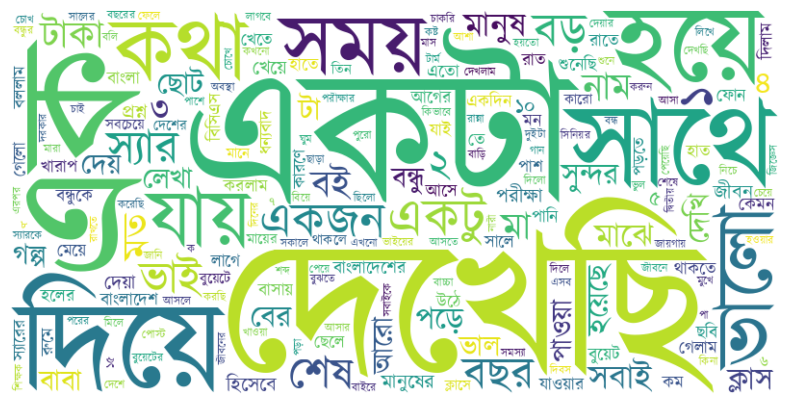

In [620]:
generate_word_cloud(male_keywords_frequency)

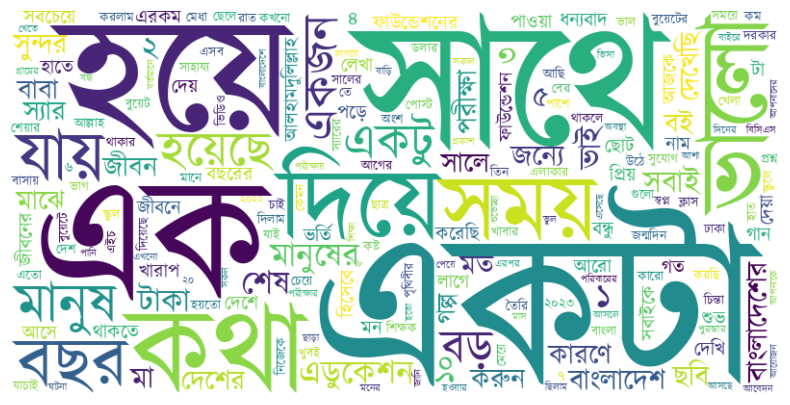

In [621]:
generate_word_cloud(female_keywords_frequency)

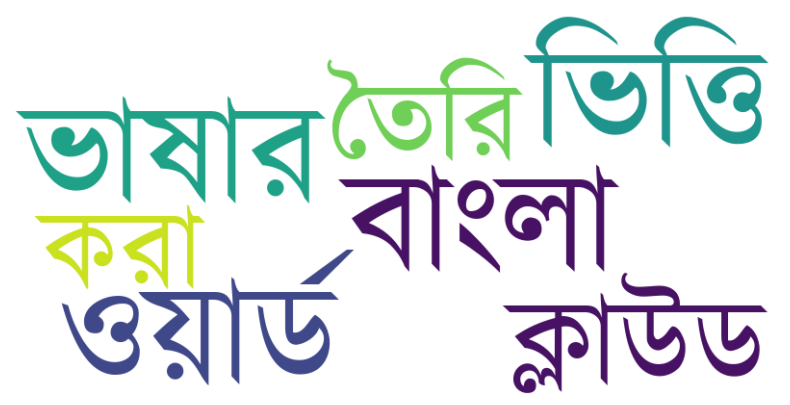

In [622]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Example Bangla text (preprocessed and tokenized)
bangla_text = "বাংলা ভাষার ওপর ভিত্তি করে ওয়ার্ড ক্লাউড তৈরি করা"

# Generate word frequencies (you need to implement this step)
word_frequencies = {'বাংলা': 1, 'ভাষার': 1, 'ভিত্তি': 1, 'ওয়ার্ড': 1, 'ক্লাউড': 1, 'তৈরি': 1, 'করা': 1}

# Create the word cloud
wordcloud = WordCloud(font_path='kalpurush.ttf', width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
# Replace 'path_to_bangla_font.ttf' with the path to your Bangla font file

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axis
plt.show()


In [11]:
count0 = count1 = count2 = count3 = count4 = count5 = countgreater5less10 = countgreater10lessequal20 = countgreater20lessequal30 = countgreater30lessequal40 = countgreater40lessequal50 = countgreater50lessequal60 = countgreater60lessequal70 = countgreater70lessequal80 = countgreater80lessequal90 = countgreater90lessequal100 = countgreater100lessequal150 = countgreater150lessequal200 = countgreater200lessequal250 = countgreater250lessequal300 = countgreater300lessequal350 = countgreater350less400 = countgreater400less450 = countgreater450less500 = countgreater500 = 0

for idx, post in enumerate(posts):
  strs = post.split()
  count0 = count0 + 1 if len(strs) == 0 else count0
  count1 = count1 + 1 if len(strs) == 1 else count1
  if count1 < 10 and len(strs) == 1:
    print("strs.len==1: ", strs)
  count2 = count2 + 1 if len(strs) == 2 else count2
  if count2 < 10 and len(strs) == 2:
    print("strslen==2: ", strs)
  count3 = count3 + 1 if len(strs) == 3 else count3
  if count2 < 10 and len(strs) == 3:
    print("strslen==3: ", strs)
  count4 = count4 + 1 if len(strs) == 4 else count4
  count5 = count5 + 1 if len(strs) == 5 else count5
  countgreater5less10 = countgreater5less10 + 1 if len(strs)>5 and len(strs) <=10 else countgreater5less10
  countgreater10lessequal20 = countgreater10lessequal20 + 1 if len(strs)>10 and len(strs)<=20 else countgreater10lessequal20
  countgreater20lessequal30 = countgreater20lessequal30 + 1 if len(strs)>20 and len(strs)<=30 else countgreater20lessequal30
  countgreater30lessequal40 = countgreater30lessequal40 + 1 if len(strs)>30 and len(strs)<=40 else countgreater30lessequal40
  countgreater40lessequal50 = countgreater40lessequal50 + 1 if len(strs)>40 and len(strs)<=50 else countgreater40lessequal50
  countgreater50lessequal60 = countgreater50lessequal60 + 1 if len(strs)>50 and len(strs)<=60 else countgreater50lessequal60
  countgreater60lessequal70 = countgreater60lessequal70 + 1 if len(strs)>60 and len(strs)<=70 else countgreater60lessequal70
  countgreater70lessequal80 = countgreater70lessequal80 + 1 if len(strs)>70 and len(strs)<=80 else countgreater70lessequal80
  countgreater80lessequal90 = countgreater80lessequal90 + 1 if len(strs)>80 and len(strs)<=90 else countgreater80lessequal90
  countgreater90lessequal100 = countgreater90lessequal100 + 1 if len(strs)>90 and len(strs)<=100 else countgreater90lessequal100
  countgreater100lessequal150 = countgreater100lessequal150 + 1 if len(strs)>100 and len(strs)<=150 else countgreater100lessequal150
  countgreater150lessequal200 = countgreater150lessequal200 + 1 if len(strs)>150 and len(strs)<=200 else countgreater150lessequal200
  countgreater200lessequal250 = countgreater200lessequal250 + 1 if len(strs)>200 and len(strs)<=250 else countgreater200lessequal250
  countgreater250lessequal300 = countgreater250lessequal300 + 1 if len(strs)>250 and len(strs)<=300 else countgreater250lessequal300
  countgreater300lessequal350 = countgreater300lessequal350 + 1 if len(strs)>300 and len(strs)<=350 else countgreater300lessequal350
  countgreater350less400 = countgreater350less400 + 1 if len(strs)>350 and len(strs)<=400 else countgreater350less400
  countgreater400less450 = countgreater400less450 + 1 if len(strs)>400 and len(strs)<=450 else countgreater400less450
  countgreater450less500 = countgreater450less500 + 1 if len(strs)>450 and len(strs)<=500 else countgreater450less500
  countgreater500 = countgreater500 + 1 if len(strs)>500 else countgreater500

total_count = count0 + count1 + count2 + count3 + count4 + count5 + countgreater5less10 + countgreater10lessequal20 + countgreater20lessequal30 + countgreater30lessequal40 + countgreater40lessequal50 + countgreater50lessequal60 + countgreater60lessequal70 + countgreater70lessequal80 + countgreater80lessequal90 + countgreater90lessequal100 + countgreater100lessequal150 + countgreater150lessequal200 + countgreater200lessequal250 + countgreater250lessequal300 + countgreater300lessequal350 + countgreater350less400 + countgreater400less450 + countgreater450less500 + countgreater500
print("total_count: ", total_count)

strs.len==1:  ['দেখেছি']
strslen==3:  ['গ্রেড', 'আসা', 'দেখেছি']
strslen==3:  ['অনলাইন', 'ক্লাসের', 'রুটিন']
strslen==2:  ['দিয়ে', 'দেখেছি']
strslen==3:  ['এক', 'একসাথে', 'দেখেছি']
strslen==2:  ['হলের', 'দেখছি']
strslen==3:  ['লেখা', 'গান', 'দেখেছি']
strslen==3:  ['পড়ে', 'ক্লাস', 'দেখেছি']
strslen==3:  ['পাবলিক', 'অভাবে', 'ভদ্র']
strslen==3:  ['ছাত্রলীগের', 'স্টল', 'দেখেছি']
strslen==3:  ['ট্যুরে', 'এভাবে', 'দেখেছি']
strslen==3:  ['রাত', 'পড়তে', 'দেখেছি']
strslen==3:  ['বুয়েটে', 'শুনতাম', 'উন্নয়ন']
strslen==3:  ['নেট', 'ল্যাবের', 'দেখছি']
strs.len==1:  ['পাপী']
strslen==3:  ['পলাশীর', 'হারিয়ে', 'দেখেছি']
strslen==3:  ['অনলাইন', 'ক্লাসে', 'শুনেছি']
strslen==3:  ['গ্রুপের', 'জানি', 'লাগতেছে']
strslen==2:  ['বাণী', 'ক্রেডিট']
strs.len==1:  ['দেখেছি']
strslen==2:  ['অপরাধে', 'শুনেছি']
strslen==3:  ['অনলাইন', 'ক্লাসে', 'শুনেছি']
strslen==3:  ['চৌধুরী', 'গ্রুপের', 'দেখেছি']
strslen==3:  ['পাপী', 'চোখে', 'দেখেছি']
strslen==2:  ['ফিস্ট', 'দেখেছি']
strs.len==1:  ['দেখেছি']
strslen==3:  ['ডাইনিং

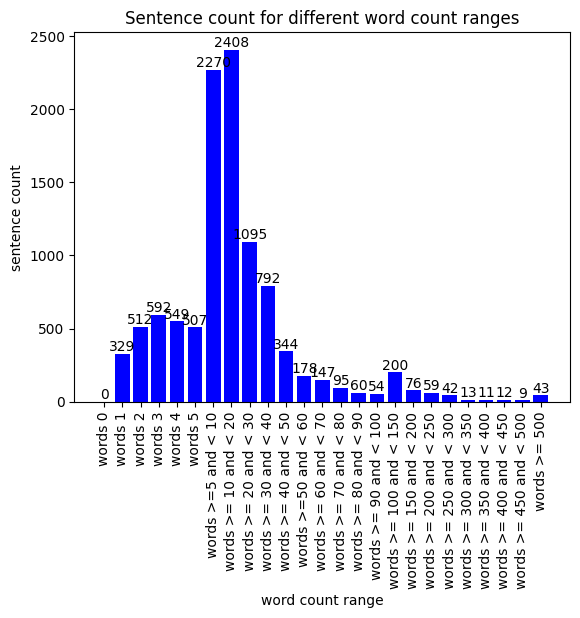

In [12]:
import matplotlib.pyplot as plt

y_axis_values = [
    count0, count1, count2, count3, count4, count5,
    countgreater5less10, countgreater10lessequal20, countgreater20lessequal30, countgreater30lessequal40, countgreater40lessequal50,
    countgreater50lessequal60, countgreater60lessequal70, countgreater70lessequal80, countgreater80lessequal90, countgreater90lessequal100,
    countgreater100lessequal150, countgreater150lessequal200, countgreater200lessequal250, countgreater250lessequal300, countgreater300lessequal350,
    countgreater350less400, countgreater400less450, countgreater450less500, countgreater500
    ]
x_axis_values = [
    "words 0", "words 1", "words 2", "words 3", "words 4", "words 5", "words >=5 and < 10", "words >= 10 and < 20", "words >= 20 and < 30", "words >= 30 and < 40", "words >= 40 and < 50",
    "words >=50 and < 60", "words >= 60 and < 70", "words >= 70 and < 80", "words >= 80 and < 90", "words >= 90 and < 100", "words >= 100 and < 150",
    "words >= 150 and < 200", "words >= 200 and < 250", "words >= 250 and < 300", "words >= 300 and < 350", "words >= 350 and < 400", "words >= 400 and < 450",
    "words >= 450 and < 500", "words >= 500"
]

# Create a bar chart
plt.bar(x_axis_values, y_axis_values, color='blue')

# Adding labels and title
plt.xlabel('word count range')
plt.ylabel('sentence count')
plt.title('Sentence count for different word count ranges')

# Adding values on top of the bars
for i, v in enumerate(y_axis_values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Rotate x-axis tick labels vertically
plt.xticks(rotation='vertical')

# Show the bar chart
plt.show()


In [625]:
posts_new = []
genders_new = []
for idx, post in enumerate(posts):
  strs = post.split()
  if len(strs) >=4 and len(strs)<=300:
    posts_new.append(post)
    genders_new.append(genders[idx])

("posts_new.len: ", len(posts_new)), ("genders_new.len: ", len(genders_new))

(('posts_new.len: ', 8876), ('genders_new.len: ', 8876))

In [626]:
mgs = len([g for g in genders_new if g == "M"])
fgs = len([g for g in genders_new if g == "F"])
("male: ", (100*mgs/(mgs+fgs))), ("female: ", (100*fgs/(mgs+fgs)))

(('male: ', 62.483100495718794), ('female: ', 37.516899504281206))

In [627]:
posts = posts_new
genders = genders_new

In [628]:
len(posts), len(genders)

(8876, 8876)

In [629]:
genders = list(pd.get_dummies(genders)['M'])

In [630]:
X=posts

In [631]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, genders, test_size=0.2, random_state=0)

In [632]:
len(X_train), len(X_test)

(7100, 1776)

In [633]:
len(y_train), len(y_test)

(7100, 1776)

In [634]:
x_train_series = pd.Series(X_train, name='text')
x_test_series = pd.Series(X_test, name='text')
y_train_series = pd.Series(y_train, name='gender')
y_test_series = pd.Series(y_test, name='gender')

In [635]:
!/usr/bin/python3.9 -m pip install tensorboardX pandas simpletransformers transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [636]:
# !/usr/bin/python3.9 -m pip install --upgrade wandb

In [637]:
from simpletransformers.classification import ClassificationModel

In [638]:
# Combine the two Series into a single DataFrame
train_df = pd.concat([x_train_series, y_train_series], axis=1)

In [639]:
test_df = pd.concat([x_test_series, y_test_series], axis=1)

In [640]:
print(train_df.dtypes)

text      object
gender      bool
dtype: object


In [641]:
print(test_df.dtypes)

text      object
gender      bool
dtype: object


In [642]:
non_integer_values = train_df['gender'].apply(lambda x: not isinstance(x, int))
print(train_df[non_integer_values])

Empty DataFrame
Columns: [text, gender]
Index: []


##Indic BERT

In [643]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Define your classification head
class Classifier(nn.Module):
    def __init__(self, input_size, num_labels):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_labels)

    def forward(self, x):
        x = self.fc(x)
        return x

# Load pre-trained model and tokenizer
model_name = "ai4bharat/indic-bert"  # or your desired model name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Define your classification head
classifier = Classifier(model.config.hidden_size, num_labels=2)

# Example dataset class for training
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Example training function
def train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    classifier.to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=3e-5)
    criterion = nn.CrossEntropyLoss()

    train_dataset = MyDataset(
        train_df['text'].values,
        train_df['gender'].values,
        tokenizer,
        max_length=max_length
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        classifier.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            logits = classifier(pooled_output)

            loss = criterion(logits, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")


In [644]:
# Example inference function
def predict(model, classifier, tokenizer, test_df, max_length, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    classifier.to(device)

    test_dataset = MyDataset(
        test_df['text'].values,
        test_df['gender'].values,  # assuming 'gender' is the target label
        tokenizer,
        max_length=max_length
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    classifier.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            logits = classifier(pooled_output)
            probabilities = nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions

# Example usage for prediction
# test_df = test_df  # Your test dataframe

# print(predictions)  # or save predictions as needed

In [645]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_scores(test_df):
    # Example usage for prediction and evaluation
    # test_df = test_df  # Your test dataframe
    predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
    true_labels = test_df['gender'].values  # Assuming 'gender' is the target label

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate precision
    precision = precision_score(true_labels, predictions)

    # Calculate recall
    recall = recall_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions)

    
    return accuracy, precision, recall, f1

# word count 1 to 300 + preprocessing (all)
# Accuracy: 0.6222114451988361
# Precision: 0.6222114451988361
# Recall: 1.0
# F1 Score: 0.7671150971599402

# word count 2 to 300 + preprocessing all
# Accuracy: 0.6302605210420842
# Precision: 0.6302605210420842
# Recall: 1.0
# F1 Score: 0.7732022126613399

# word count 3 to 300 + preprocessing all
# Accuracy: 0.6203801478352693
# Precision: 0.6203801478352693
# Recall: 1.0
# F1 Score: 0.7657217334636689

# word count 4 to 300 + preprocessing all
# Accuracy: 0.607545045045045
# Precision: 0.607545045045045
# Recall: 1.0
# F1 Score: 0.7558669001751314

# word count 5 to 300 + preprocessing all
# Accuracy: 0.634453781512605
# Precision: 0.634453781512605
# Recall: 1.0
# F1 Score: 0.7763496143958869

# word count 5 to 300 + without stopword removal
# Accuracy: 0.6169623059866962
# Precision: 0.6169623059866962
# Recall: 1.0
# F1 Score: 0.7631127871100446

# word count 4 to 300 + without stopword removal
# Accuracy: 0.635588705380927
# Precision: 0.635588705380927
# Recall: 1.0
# F1 Score: 0.7771986970684039

# word count 3 to 300 + without stopword removal
# Accuracy: 0.6246153846153846
# Precision: 0.6246153846153846
# Recall: 1.0
# F1 Score: 0.7689393939393939

# word count 2 to 300 + without stopword removal
# Accuracy: 0.6301642608262817
# Precision: 0.6301642608262817
# Recall: 1.0
# F1 Score: 0.7731297709923665

# word count 1 to 300 + without stopword removal
# Accuracy: 0.61083984375
# Precision: 0.61083984375
# Recall: 1.0
# F1 Score: 0.758411639890876

### epoch 2

In [646]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 2  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/2:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/1714820176.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/2: 100%|██████████| 592/592 [00:35<00:00, 16.58it/s]


Epoch 1/2, Loss: 0.6756603589935882


Epoch 2/2: 100%|██████████| 592/592 [00:35<00:00, 16.49it/s]


Epoch 2/2, Loss: 0.6619739843582785


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.06it/s]


Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


### epoch 5

In [647]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 5  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/5:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/1714820176.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/5: 100%|██████████| 592/592 [00:35<00:00, 16.46it/s]


Epoch 1/5, Loss: 0.6592048533462189


Epoch 2/5: 100%|██████████| 592/592 [00:35<00:00, 16.48it/s]


Epoch 2/5, Loss: 0.6587366212562129


Epoch 3/5: 100%|██████████| 592/592 [00:35<00:00, 16.50it/s]


Epoch 3/5, Loss: 0.6586155572251694


Epoch 4/5: 100%|██████████| 592/592 [00:35<00:00, 16.49it/s]


Epoch 4/5, Loss: 0.6584141459316015


Epoch 5/5: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 5/5, Loss: 0.6583191685479235


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.19it/s]


Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


### epoch 10

In [648]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 5  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/5:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/1714820176.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/5: 100%|██████████| 592/592 [00:35<00:00, 16.53it/s]


Epoch 1/5, Loss: 0.6581998515773464


Epoch 2/5: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 2/5, Loss: 0.6581546722131001


Epoch 3/5: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 3/5, Loss: 0.6579794902857896


Epoch 4/5: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 4/5, Loss: 0.6578905573869879


Epoch 5/5: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 5/5, Loss: 0.6577232780589445


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.17it/s]


Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


### epoch 15

In [649]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 15  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/15:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/1714820176.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/15: 100%|██████████| 592/592 [00:35<00:00, 16.53it/s]


Epoch 1/15, Loss: 0.6576098890320675


Epoch 2/15: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 2/15, Loss: 0.6575274319966903


Epoch 3/15: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 3/15, Loss: 0.657294833579579


Epoch 4/15: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 4/15, Loss: 0.6572439125361474


Epoch 5/15: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 5/15, Loss: 0.6571767225458816


Epoch 6/15: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 6/15, Loss: 0.6569817887770163


Epoch 7/15: 100%|██████████| 592/592 [00:35<00:00, 16.53it/s]


Epoch 7/15, Loss: 0.6569339693901507


Epoch 8/15: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 8/15, Loss: 0.6568473481346626


Epoch 9/15: 100%|██████████| 592/592 [00:35<00:00, 16.53it/s]


Epoch 9/15, Loss: 0.6567426183437174


Epoch 10/15: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 10/15, Loss: 0.6565677363526177


Epoch 11/15: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 11/15, Loss: 0.656411797815078


Epoch 12/15: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 12/15, Loss: 0.6563747682784861


Epoch 13/15: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 13/15, Loss: 0.6562389506882912


Epoch 14/15: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 14/15, Loss: 0.6562266565255217


Epoch 15/15: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 15/15, Loss: 0.6560678070260061


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.20it/s]


Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


### epoch 20

In [650]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 20  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/20:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/1714820176.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/20: 100%|██████████| 592/592 [00:35<00:00, 16.53it/s]


Epoch 1/20, Loss: 0.6559758497452414


Epoch 2/20: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 2/20, Loss: 0.6558701225833313


Epoch 3/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 3/20, Loss: 0.6557141512229636


Epoch 4/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 4/20, Loss: 0.6556181319662042


Epoch 5/20: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 5/20, Loss: 0.6554708569939878


Epoch 6/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 6/20, Loss: 0.6553606746869313


Epoch 7/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 7/20, Loss: 0.6552876814998485


Epoch 8/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 8/20, Loss: 0.6551008271305142


Epoch 9/20: 100%|██████████| 592/592 [00:35<00:00, 16.53it/s]


Epoch 9/20, Loss: 0.6550704475391556


Epoch 10/20: 100%|██████████| 592/592 [00:35<00:00, 16.53it/s]


Epoch 10/20, Loss: 0.6550662060947837


Epoch 11/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 11/20, Loss: 0.6549093382483399


Epoch 12/20: 100%|██████████| 592/592 [00:35<00:00, 16.51it/s]


Epoch 12/20, Loss: 0.6547967001191668


Epoch 13/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 13/20, Loss: 0.6547399389784079


Epoch 14/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 14/20, Loss: 0.6545448305739744


Epoch 15/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 15/20, Loss: 0.6544852245196298


Epoch 16/20: 100%|██████████| 592/592 [00:35<00:00, 16.53it/s]


Epoch 16/20, Loss: 0.654527051626025


Epoch 17/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 17/20, Loss: 0.6543336233275162


Epoch 18/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 18/20, Loss: 0.6542432038365183


Epoch 19/20: 100%|██████████| 592/592 [00:35<00:00, 16.52it/s]


Epoch 19/20, Loss: 0.6541544868031869


Epoch 20/20: 100%|██████████| 592/592 [00:35<00:00, 16.53it/s]


Epoch 20/20, Loss: 0.6540790407138096


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.18it/s]


Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


### epoch 25

In [667]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 25  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/25:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/25: 100%|██████████| 592/592 [01:57<00:00,  5.06it/s]


Epoch 1/25, Loss: 0.5385515073163284


Epoch 2/25: 100%|██████████| 592/592 [01:57<00:00,  5.04it/s]


Epoch 2/25, Loss: 0.5427505710741153


Epoch 3/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 3/25, Loss: 0.5383733006294917


Epoch 4/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 4/25, Loss: 0.5386375296055466


Epoch 5/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 5/25, Loss: 0.5429178115634902


Epoch 6/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 6/25, Loss: 0.5361923423620898


Epoch 7/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 7/25, Loss: 0.5359380060957896


Epoch 8/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 8/25, Loss: 0.5378457881459916


Epoch 9/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 9/25, Loss: 0.5373700798262615


Epoch 10/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 10/25, Loss: 0.5362144187092781


Epoch 11/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 11/25, Loss: 0.5354630362645194


Epoch 12/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 12/25, Loss: 0.5328038010645557


Epoch 13/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 13/25, Loss: 0.5354508053813432


Epoch 14/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 14/25, Loss: 0.5380752014650686


Epoch 15/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 15/25, Loss: 0.5340259652081374


Epoch 16/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 16/25, Loss: 0.535585240309907


Epoch 17/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 17/25, Loss: 0.5347986185067409


Epoch 18/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 18/25, Loss: 0.5363786455898268


Epoch 19/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 19/25, Loss: 0.5321366632155873


Epoch 20/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 20/25, Loss: 0.5306759552426032


Epoch 21/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 21/25, Loss: 0.5339391620426968


Epoch 22/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 22/25, Loss: 0.5399447605265556


Epoch 23/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 23/25, Loss: 0.5321286681385057


Epoch 24/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 24/25, Loss: 0.5328870863225814


Epoch 25/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 25/25, Loss: 0.5338224684064453


Predicting: 100%|██████████| 148/148 [00:10<00:00, 13.64it/s]

Accuracy: 0.7342342342342343
Precision: 0.7445608380338437
Recall: 0.8563484708063022
F1 Score: 0.7965517241379311


Fine-tune MuRIL

In [651]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Define your classification head
class Classifier(nn.Module):
    def __init__(self, input_size, num_labels):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_labels)

    def forward(self, x):
        x = self.fc(x)
        return x

# Load pre-trained model and tokenizer
# model_name = "ai4bharat/indic-bert"  # or your desired model name
model_name = "google/muril-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Define your classification head
classifier = Classifier(model.config.hidden_size, num_labels=2)

# Example dataset class for training
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Example training function
def train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    classifier.to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=3e-5)
    criterion = nn.CrossEntropyLoss()

    train_dataset = MyDataset(
        train_df['text'].values,
        train_df['gender'].values,
        tokenizer,
        max_length=max_length
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        classifier.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            logits = classifier(pooled_output)

            loss = criterion(logits, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")



In [652]:
# Example inference function
def predict(model, classifier, tokenizer, test_df, max_length, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    classifier.to(device)

    test_dataset = MyDataset(
        test_df['text'].values,
        test_df['gender'].values,  # assuming 'gender' is the target label
        tokenizer,
        max_length=max_length
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    classifier.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            logits = classifier(pooled_output)
            probabilities = nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions

In [653]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_scores(test_df):
    # Example usage for prediction and evaluation
    test_df = test_df  # Your test dataframe
    predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
    true_labels = test_df['gender'].values  # Assuming 'gender' is the target label

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate precision
    precision = precision_score(true_labels, predictions)

    # Calculate recall
    recall = recall_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1

# 1 to 300 word count + preprocessing (all)
# Accuracy: 0.6222114451988361
# Precision: 0.6222114451988361
# Recall: 1.0
# F1 Score: 0.7671150971599402

# 2 to 300 word count + preprocessing (all)
# Accuracy: 0.6302605210420842
# Precision: 0.6302605210420842
# Recall: 1.0
# F1 Score: 0.7732022126613399

# 3 to 300 word count + preprocessing (all)
# Accuracy: 0.6203801478352693
# Precision: 0.6203801478352693
# Recall: 1.0
# F1 Score: 0.7657217334636689

# 4 to 300 word count + preprocessing (all)
# Accuracy: 0.607545045045045
# Precision: 0.607545045045045
# Recall: 1.0
# F1 Score: 0.7558669001751314

# 5 to 300 word count + preprocessing (all)
# Accuracy: 0.634453781512605
# Precision: 0.634453781512605
# Recall: 1.0
# F1 Score: 0.7763496143958869

# 5 to 300 word count + without stopword removal
# Accuracy: 0.6169623059866962
# Precision: 0.6169623059866962
# Recall: 1.0
# F1 Score: 0.7631127871100446

# 4 to 300 word count + without stopword removal
# Accuracy: 0.635588705380927
# Precision: 0.635588705380927
# Recall: 1.0
# F1 Score: 0.7771986970684039

# 3 to 300 word count + without stopword removal
# Accuracy: 0.6246153846153846
# Precision: 0.6246153846153846
# Recall: 1.0
# F1 Score: 0.7689393939393939

# 2 to 300 word count + without stopword removal
# Accuracy: 0.6301642608262817
# Precision: 0.6301642608262817
# Recall: 1.0
# F1 Score: 0.7731297709923665

# 1 to 300 word count + without stopword removal
# Accuracy: 0.61083984375
# Precision: 0.61083984375
# Recall: 1.0
# F1 Score: 0.758411639890876

### epoch 2

In [654]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 2  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)
# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/2:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/3965504411.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/2: 100%|██████████| 592/592 [00:36<00:00, 16.18it/s]


Epoch 1/2, Loss: 0.6884764725896152


Epoch 2/2: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 2/2, Loss: 0.6801902996124448


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.59it/s]

Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


### epoch 5

In [655]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 5  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)
# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/5:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/3965504411.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/5: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 1/5, Loss: 0.674022782493282


Epoch 2/5: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 2/5, Loss: 0.6693243292739263


Epoch 3/5: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 3/5, Loss: 0.6661387537983624


Epoch 4/5: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 4/5, Loss: 0.6638533152841233


Epoch 5/5: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 5/5, Loss: 0.6622660347336048


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.59it/s]

Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


### epoch 10

In [656]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 10  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)
# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/10:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/3965504411.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/10: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 1/10, Loss: 0.6611364729501106


Epoch 2/10: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 2/10, Loss: 0.6605215872058997


Epoch 3/10: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 3/10, Loss: 0.6598852360369386


Epoch 4/10: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 4/10, Loss: 0.6594782159537882


Epoch 5/10: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 5/10, Loss: 0.6592367741505842


Epoch 6/10: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 6/10, Loss: 0.6590903424532026


Epoch 7/10: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 7/10, Loss: 0.6590111936266357


Epoch 8/10: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 8/10, Loss: 0.6587817665390872


Epoch 9/10: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 9/10, Loss: 0.6586689817140231


Epoch 10/10: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 10/10, Loss: 0.6586607347267706


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.57it/s]

Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


### epoch 15

In [657]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 15  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)
# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/15:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/3965504411.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/15: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 1/15, Loss: 0.6585011402698787


Epoch 2/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 2/15, Loss: 0.6584687705176908


Epoch 3/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 3/15, Loss: 0.6584992276857028


Epoch 4/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 4/15, Loss: 0.6583323207860058


Epoch 5/15: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 5/15, Loss: 0.6584282462057229


Epoch 6/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 6/15, Loss: 0.658258239763814


Epoch 7/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 7/15, Loss: 0.6582628256465132


Epoch 8/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 8/15, Loss: 0.6581177699404794


Epoch 9/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 9/15, Loss: 0.6580917502979975


Epoch 10/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 10/15, Loss: 0.6580623473367981


Epoch 11/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 11/15, Loss: 0.6580512295099529


Epoch 12/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 12/15, Loss: 0.657982898020261


Epoch 13/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 13/15, Loss: 0.6579934643531168


Epoch 14/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 14/15, Loss: 0.657877267665557


Epoch 15/15: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 15/15, Loss: 0.6578885672261586


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.57it/s]


Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


### epoch 20

In [658]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 20  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)
# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/20:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/3965504411.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/20: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 1/20, Loss: 0.6578528624833435


Epoch 2/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 2/20, Loss: 0.6577323653005265


Epoch 3/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 3/20, Loss: 0.6577711872051697


Epoch 4/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 4/20, Loss: 0.6576925188907095


Epoch 5/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 5/20, Loss: 0.657621989177691


Epoch 6/20: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 6/20, Loss: 0.6575373223403821


Epoch 7/20: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 7/20, Loss: 0.6574697392313061


Epoch 8/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 8/20, Loss: 0.657421755377908


Epoch 9/20: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 9/20, Loss: 0.657256635812086


Epoch 10/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 10/20, Loss: 0.6574388832558651


Epoch 11/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 11/20, Loss: 0.6573663716884078


Epoch 12/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 12/20, Loss: 0.6572822489951914


Epoch 13/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 13/20, Loss: 0.6570768193215937


Epoch 14/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 14/20, Loss: 0.6571592202259077


Epoch 15/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 15/20, Loss: 0.6571013918901617


Epoch 16/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 16/20, Loss: 0.657062554127864


Epoch 17/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 17/20, Loss: 0.6569813487396853


Epoch 18/20: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 18/20, Loss: 0.6568374015088823


Epoch 19/20: 100%|██████████| 592/592 [00:36<00:00, 16.17it/s]


Epoch 19/20, Loss: 0.6568972732166987


Epoch 20/20: 100%|██████████| 592/592 [00:36<00:00, 16.16it/s]


Epoch 20/20, Loss: 0.6568120055504747


Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.60it/s]

Accuracy: 0.607545045045045
Precision: 0.607545045045045
Recall: 1.0
F1 Score: 0.7558669001751314


In [668]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 25  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)
# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/25:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/25: 100%|██████████| 592/592 [01:57<00:00,  5.05it/s]


Epoch 1/25, Loss: 0.5311364238024563


Epoch 2/25: 100%|██████████| 592/592 [01:57<00:00,  5.05it/s]


Epoch 2/25, Loss: 0.5315176456965305


Epoch 3/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 3/25, Loss: 0.534760336970558


Epoch 4/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 4/25, Loss: 0.5257279388858257


Epoch 5/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 5/25, Loss: 0.5310978815966362


Epoch 6/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 6/25, Loss: 0.533732232713216


Epoch 7/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 7/25, Loss: 0.5310617449215135


Epoch 8/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 8/25, Loss: 0.5346492345419687


Epoch 9/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 9/25, Loss: 0.5311382663612431


Epoch 10/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 10/25, Loss: 0.5332525560279956


Epoch 11/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 11/25, Loss: 0.534137925561014


Epoch 12/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 12/25, Loss: 0.5325681096496614


Epoch 13/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 13/25, Loss: 0.5289775226265192


Epoch 14/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 14/25, Loss: 0.5344226623608453


Epoch 15/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 15/25, Loss: 0.5286828114625972


Epoch 16/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 16/25, Loss: 0.5299815142627906


Epoch 17/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 17/25, Loss: 0.5328990378593271


Epoch 18/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 18/25, Loss: 0.528314400741176


Epoch 19/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 19/25, Loss: 0.5343765777762275


Epoch 20/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 20/25, Loss: 0.527636395364597


Epoch 21/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 21/25, Loss: 0.5316598738820569


Epoch 22/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 22/25, Loss: 0.5276107662231535


Epoch 23/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 23/25, Loss: 0.5302998970791295


Epoch 24/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 24/25, Loss: 0.5323865857176684


Epoch 25/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 25/25, Loss: 0.5310949065999405


Predicting: 100%|██████████| 148/148 [00:10<00:00, 13.64it/s]

Accuracy: 0.7257882882882883
Precision: 0.7316118935837246
Recall: 0.8665430954587581
F1 Score: 0.7933814170555791


In [659]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Define your classification head
class Classifier(nn.Module):
    def __init__(self, input_size, num_labels):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_labels)

    def forward(self, x):
        x = self.fc(x)
        return x

# Load pre-trained model and tokenizer
# model_name = "ai4bharat/indic-bert"  # or your desired model name
model_name = "google/muril-large-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Define your classification head
classifier = Classifier(model.config.hidden_size, num_labels=2)

# Example dataset class for training
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Example training function
def train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    classifier.to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=3e-5)
    criterion = nn.CrossEntropyLoss()

    train_dataset = MyDataset(
        train_df['text'].values,
        train_df['gender'].values,
        tokenizer,
        max_length=max_length
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        classifier.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            logits = classifier(pooled_output)

            loss = criterion(logits, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

Some weights of the model checkpoint at google/muril-large-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [660]:
# Example inference function
def predict(model, classifier, tokenizer, test_df, max_length, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    classifier.to(device)

    test_dataset = MyDataset(
        test_df['text'].values,
        test_df['gender'].values,  # assuming 'gender' is the target label
        tokenizer,
        max_length=max_length
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    classifier.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            logits = classifier(pooled_output)
            probabilities = nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions


In [661]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_scores(test_df):
    # Example usage for prediction and evaluation
    test_df = test_df  # Your test dataframe
    predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
    true_labels = test_df['gender'].values  # Assuming 'gender' is the target label

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate precision
    precision = precision_score(true_labels, predictions)

    # Calculate recall
    recall = recall_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1

# 1 to 300 word count + preprocessing (all)
# Accuracy: 0.6842870999030067
# Precision: 0.7041343669250646
# Recall: 0.8495713172252534
# F1 Score: 0.7700459201695514

# word count 2 to 300 + preprocessing (all)
# Accuracy: 0.6793587174348698
# Precision: 0.7043650793650794
# Recall: 0.8465818759936407
# F1 Score: 0.7689530685920578

# word count 3 to 300 + preprocessing (all)
# Accuracy: 0.672650475184794
# Precision: 0.6803118908382066
# Recall: 0.8910638297872341
# F1 Score: 0.7715549005158437

# word count 4 to 300 + preprocessing (all)
# Accuracy: 0.6649774774774775
# Precision: 0.6632928475033738
# Recall: 0.9110287303058388
# F1 Score: 0.7676688793440063

# word count 5 to 300 + preprocessing (all)
# Accuracy: 0.6800720288115246
# Precision: 0.6952309985096871
# Recall: 0.8826868495742668
# F1 Score: 0.7778240933722385

# word count 5 to 300 + without stopword removal
# Accuracy: 0.6762749445676275
# Precision: 0.6798096532970768
# Recall: 0.8984725965858041
# F1 Score: 0.7739938080495357

# word count 4 to 300 + without stopword removal
# Accuracy: 0.6824720298348428
# Precision: 0.7106563161609033
# Recall: 0.8440905280804694
# F1 Score: 0.7716475095785441

# word count 3 to 300 + without stopword removal
# Accuracy: 0.6917948717948718
# Precision: 0.7120274914089347
# Recall: 0.8505747126436781
# F1 Score: 0.7751589973812196

# word count 2 to 300 + without stopword removal
# Accuracy: 0.6913887506222001
# Precision: 0.7125
# Recall: 0.8554502369668247
# F1 Score: 0.7774587221823402

### epoch 2

In [662]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 2  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)

accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/2:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/2: 100%|██████████| 592/592 [01:56<00:00,  5.07it/s]


Epoch 1/2, Loss: 0.6560417771641467


Epoch 2/2: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 2/2, Loss: 0.6318816384552298


Predicting: 100%|██████████| 148/148 [00:10<00:00, 13.63it/s]

Accuracy: 0.6317567567567568
Precision: 0.6294942108470445
Recall: 0.9573679332715477
F1 Score: 0.7595588235294117


### epoch 5

In [663]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 5  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/5:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/5: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 1/5, Loss: 0.619759376890756


Epoch 2/5: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 2/5, Loss: 0.6083379245388347


Epoch 3/5: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 3/5, Loss: 0.5998009814301858


Epoch 4/5: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 4/5, Loss: 0.5942502871055055


Epoch 5/5: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 5/5, Loss: 0.5885662400239223


Predicting: 100%|██████████| 148/148 [00:10<00:00, 13.64it/s]

Accuracy: 0.6813063063063063
Precision: 0.6862745098039216
Recall: 0.8758109360518999
F1 Score: 0.7695439739413681


### epoch 10

In [664]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 10  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/10:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 1/10, Loss: 0.5834870059043169


Epoch 2/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 2/10, Loss: 0.5816006060387637


Epoch 3/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 3/10, Loss: 0.5786215409737181


Epoch 4/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 4/10, Loss: 0.5780488821501667


Epoch 5/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 5/10, Loss: 0.5716813269096452


Epoch 6/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 6/10, Loss: 0.57156727120683


Epoch 7/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 7/10, Loss: 0.5671948872103885


Epoch 8/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 8/10, Loss: 0.5668329537116192


Epoch 9/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 9/10, Loss: 0.5645163817884954


Epoch 10/10: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 10/10, Loss: 0.5631755739450455


Predicting: 100%|██████████| 148/148 [00:10<00:00, 13.64it/s]

Accuracy: 0.7088963963963963
Precision: 0.7295751633986928
Recall: 0.8276181649675626
F1 Score: 0.7755102040816326


### epoch 15

In [665]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 15  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/15:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 1/15, Loss: 0.5627523750268124


Epoch 2/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 2/15, Loss: 0.5580333549327947


Epoch 3/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 3/15, Loss: 0.5579984389950294


Epoch 4/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 4/15, Loss: 0.557291898775745


Epoch 5/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 5/15, Loss: 0.5603701851859286


Epoch 6/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 6/15, Loss: 0.5568753694863738


Epoch 7/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 7/15, Loss: 0.5550944558470636


Epoch 8/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 8/15, Loss: 0.5526154959020583


Epoch 9/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 9/15, Loss: 0.5536681577009527


Epoch 10/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 10/15, Loss: 0.5515054839386327


Epoch 11/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 11/15, Loss: 0.5521914798867058


Epoch 12/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 12/15, Loss: 0.5469941639819661


Epoch 13/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 13/15, Loss: 0.5475747552071069


Epoch 14/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 14/15, Loss: 0.5489965022566754


Epoch 15/15: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 15/15, Loss: 0.5501059849268278


Predicting: 100%|██████████| 148/148 [00:10<00:00, 13.63it/s]

Accuracy: 0.7246621621621622
Precision: 0.7337559429477021
Recall: 0.8582020389249305
F1 Score: 0.7911149081589065


### epoch 20

In [666]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 20  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/20:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 1/20, Loss: 0.5463320666773094


Epoch 2/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 2/20, Loss: 0.5513450672749329


Epoch 3/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 3/20, Loss: 0.5413531651720405


Epoch 4/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 4/20, Loss: 0.5449231405415245


Epoch 5/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 5/20, Loss: 0.5454481643549091


Epoch 6/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 6/20, Loss: 0.5403059197187021


Epoch 7/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 7/20, Loss: 0.5437266469706554


Epoch 8/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 8/20, Loss: 0.5442462577106985


Epoch 9/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 9/20, Loss: 0.5424322207030412


Epoch 10/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 10/20, Loss: 0.542144229887305


Epoch 11/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 11/20, Loss: 0.5427975052011174


Epoch 12/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 12/20, Loss: 0.5411340976385651


Epoch 13/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 13/20, Loss: 0.5414607124654828


Epoch 14/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 14/20, Loss: 0.537633508745883


Epoch 15/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 15/20, Loss: 0.5422139167282227


Epoch 16/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 16/20, Loss: 0.539789032216209


Epoch 17/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 17/20, Loss: 0.5409388842715604


Epoch 18/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 18/20, Loss: 0.5341125467188053


Epoch 19/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 19/20, Loss: 0.5398741729708539


Epoch 20/20: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 20/20, Loss: 0.5378366592969444


Predicting: 100%|██████████| 148/148 [00:10<00:00, 13.64it/s]

Accuracy: 0.731418918918919
Precision: 0.742741935483871
Recall: 0.8535681186283596
F1 Score: 0.7943078913324709


### Epoch 25

In [669]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 25  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/25:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/25: 100%|██████████| 592/592 [01:57<00:00,  5.06it/s]


Epoch 1/25, Loss: 0.5321106148783017


Epoch 2/25: 100%|██████████| 592/592 [01:57<00:00,  5.04it/s]


Epoch 2/25, Loss: 0.5277494937936599


Epoch 3/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 3/25, Loss: 0.5279287780710572


Epoch 4/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 4/25, Loss: 0.5244795365158368


Epoch 5/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 5/25, Loss: 0.5324762908842515


Epoch 6/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 6/25, Loss: 0.525888725863518


Epoch 7/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 7/25, Loss: 0.5286659792418013


Epoch 8/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 8/25, Loss: 0.5292801006218871


Epoch 9/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 9/25, Loss: 0.5268462105729693


Epoch 10/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 10/25, Loss: 0.5300870172024982


Epoch 11/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 11/25, Loss: 0.5304061267524958


Epoch 12/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 12/25, Loss: 0.5301204856636154


Epoch 13/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 13/25, Loss: 0.5259999613202101


Epoch 14/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 14/25, Loss: 0.5280061347057691


Epoch 15/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 15/25, Loss: 0.528626463275302


Epoch 16/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 16/25, Loss: 0.530201973469072


Epoch 17/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 17/25, Loss: 0.5289592478373969


Epoch 18/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 18/25, Loss: 0.5245097943556469


Epoch 19/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 19/25, Loss: 0.5286384065811699


Epoch 20/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 20/25, Loss: 0.5304760484125566


Epoch 21/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 21/25, Loss: 0.528869238304528


Epoch 22/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 22/25, Loss: 0.5257053707248053


Epoch 23/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 23/25, Loss: 0.5287350096009873


Epoch 24/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 24/25, Loss: 0.526079881231527


Epoch 25/25: 100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Epoch 25/25, Loss: 0.5256629346844715


Predicting: 100%|██████████| 148/148 [00:10<00:00, 13.64it/s]

Accuracy: 0.7274774774774775
Precision: 0.7265803503427266
Recall: 0.8841519925857275
F1 Score: 0.7976588628762542


### Bangla BERT

In [673]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Define your classification head
class Classifier(nn.Module):
    def __init__(self, input_size, num_labels):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_labels)

    def forward(self, x):
        x = self.fc(x)
        return x

# Load pre-trained model and tokenizer
model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Define your classification head
classifier = Classifier(model.config.hidden_size, num_labels=2)  # Assuming binary classification

# Example dataset class for training
class MyBanglaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Example training function
def train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    classifier.to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=3e-5)
    criterion = nn.CrossEntropyLoss()

    train_dataset = MyBanglaDataset(
        train_df['text'].values,
        train_df['gender'].values,
        tokenizer,
        max_length=max_length
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        classifier.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            logits = classifier(pooled_output)

            loss = criterion(logits, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

# Now you can use the train function to train the Bangla BERT model.


In [674]:
# Example inference function
def predict(model, classifier, tokenizer, test_df, max_length, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    classifier.to(device)

    test_dataset = MyDataset(
        test_df['text'].values,
        test_df['gender'].values,  # assuming 'gender' is the target label
        tokenizer,
        max_length=max_length
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    classifier.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            logits = classifier(pooled_output)
            probabilities = nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions


In [675]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_scores(test_df):
    # Example usage for prediction and evaluation
    test_df = test_df  # Your test dataframe
    predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
    true_labels = test_df['gender'].values  # Assuming 'gender' is the target label

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate precision
    precision = precision_score(true_labels, predictions)

    # Calculate recall
    recall = recall_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1

### epoch 2

In [676]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 2  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/2:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/4139861702.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/2: 100%|██████████| 592/592 [00:36<00:00, 16.39it/s]


Epoch 1/2, Loss: 0.667825553868268


Epoch 2/2: 100%|██████████| 592/592 [00:36<00:00, 16.23it/s]


Epoch 2/2, Loss: 0.6322204906090692


Predicting:   0%|          | 0/148 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Predicting: 100%|██████████| 148/148 [00:03<00:00, 40.79it/s]


Accuracy: 0.6300675675675675
Precision: 0.6380890052356021
Recall: 0.9036144578313253
F1 Score: 0.7479861910241657


### epoch 5

In [677]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 5  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/5:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/4139861702.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/5: 100%|██████████| 592/592 [00:36<00:00, 16.33it/s]


Epoch 1/5, Loss: 0.6225987206137663


Epoch 2/5: 100%|██████████| 592/592 [00:36<00:00, 16.19it/s]


Epoch 2/5, Loss: 0.6127550569237084


Epoch 3/5: 100%|██████████| 592/592 [00:36<00:00, 16.18it/s]


Epoch 3/5, Loss: 0.6072712339259483


Epoch 4/5: 100%|██████████| 592/592 [00:36<00:00, 16.21it/s]


Epoch 4/5, Loss: 0.6020711605512613


Epoch 5/5: 100%|██████████| 592/592 [00:36<00:00, 16.23it/s]


Epoch 5/5, Loss: 0.5983514348800117


Predicting:   0%|          | 0/148 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Predicting: 100%|██████████| 148/148 [00:03<00:00, 40.90it/s]


Accuracy: 0.661036036036036
Precision: 0.6664340544312631
Recall: 0.8850787766450418
F1 Score: 0.7603503184713376


### epoch 10

In [678]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 10  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/10:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/4139861702.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/10: 100%|██████████| 592/592 [00:36<00:00, 16.39it/s]


Epoch 1/10, Loss: 0.5933159772508048


Epoch 2/10: 100%|██████████| 592/592 [00:36<00:00, 16.24it/s]


Epoch 2/10, Loss: 0.5916651137475226


Epoch 3/10: 100%|██████████| 592/592 [00:36<00:00, 16.22it/s]


Epoch 3/10, Loss: 0.5907771310492141


Epoch 4/10: 100%|██████████| 592/592 [00:36<00:00, 16.23it/s]


Epoch 4/10, Loss: 0.5865938655931402


Epoch 5/10: 100%|██████████| 592/592 [00:36<00:00, 16.24it/s]


Epoch 5/10, Loss: 0.5876240527911766


Epoch 6/10: 100%|██████████| 592/592 [00:36<00:00, 16.25it/s]


Epoch 6/10, Loss: 0.5860811767445223


Epoch 7/10: 100%|██████████| 592/592 [00:36<00:00, 16.26it/s]


Epoch 7/10, Loss: 0.5856404074945966


Epoch 8/10: 100%|██████████| 592/592 [00:36<00:00, 16.26it/s]


Epoch 8/10, Loss: 0.5828694412233056


Epoch 9/10: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 9/10, Loss: 0.5827074427963108


Epoch 10/10: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 10/10, Loss: 0.5793737289369911


Predicting:   0%|          | 0/148 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.02it/s]


Accuracy: 0.6841216216216216
Precision: 0.6992307692307692
Recall: 0.8424467099165894
F1 Score: 0.7641866330390921


### epoch 15

In [679]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 15  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/15:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/4139861702.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/15: 100%|██████████| 592/592 [00:36<00:00, 16.36it/s]


Epoch 1/15, Loss: 0.5805271649229768


Epoch 2/15: 100%|██████████| 592/592 [00:36<00:00, 16.35it/s]


Epoch 2/15, Loss: 0.5797055122518057


Epoch 3/15: 100%|██████████| 592/592 [00:36<00:00, 16.34it/s]


Epoch 3/15, Loss: 0.5763357247955896


Epoch 4/15: 100%|██████████| 592/592 [00:36<00:00, 16.35it/s]


Epoch 4/15, Loss: 0.577685924297249


Epoch 5/15: 100%|██████████| 592/592 [00:36<00:00, 16.34it/s]


Epoch 5/15, Loss: 0.5740951825235341


Epoch 6/15: 100%|██████████| 592/592 [00:36<00:00, 16.34it/s]


Epoch 6/15, Loss: 0.5730252101312618


Epoch 7/15: 100%|██████████| 592/592 [00:36<00:00, 16.35it/s]


Epoch 7/15, Loss: 0.5733919579132989


Epoch 8/15: 100%|██████████| 592/592 [00:36<00:00, 16.35it/s]


Epoch 8/15, Loss: 0.5725301607335741


Epoch 9/15: 100%|██████████| 592/592 [00:36<00:00, 16.35it/s]


Epoch 9/15, Loss: 0.5678953854870554


Epoch 10/15: 100%|██████████| 592/592 [00:36<00:00, 16.35it/s]


Epoch 10/15, Loss: 0.5705601875040982


Epoch 11/15: 100%|██████████| 592/592 [00:36<00:00, 16.35it/s]


Epoch 11/15, Loss: 0.5688192759313293


Epoch 12/15: 100%|██████████| 592/592 [00:36<00:00, 16.35it/s]


Epoch 12/15, Loss: 0.5680829659356056


Epoch 13/15: 100%|██████████| 592/592 [00:36<00:00, 16.35it/s]


Epoch 13/15, Loss: 0.5709709322231041


Epoch 14/15: 100%|██████████| 592/592 [00:36<00:00, 16.34it/s]


Epoch 14/15, Loss: 0.5688996516872902


Epoch 15/15: 100%|██████████| 592/592 [00:36<00:00, 16.33it/s]


Epoch 15/15, Loss: 0.5666072139063397


Predicting:   0%|          | 0/148 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.04it/s]


Accuracy: 0.6891891891891891
Precision: 0.6979714500375658
Recall: 0.860982391102873
F1 Score: 0.7709543568464731


### epoch 20

In [680]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 20  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Epoch 1/20:   0%|          | 0/592 [00:00<?, ?it/s]/tmp/ipykernel_1806527/4139861702.py:50: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Epoch 1/20: 100%|██████████| 592/592 [00:36<00:00, 16.39it/s]


Epoch 1/20, Loss: 0.5659552699307332


Epoch 2/20: 100%|██████████| 592/592 [00:36<00:00, 16.24it/s]


Epoch 2/20, Loss: 0.5647010087614527


Epoch 3/20: 100%|██████████| 592/592 [00:36<00:00, 16.22it/s]


Epoch 3/20, Loss: 0.5670114826612376


Epoch 4/20: 100%|██████████| 592/592 [00:36<00:00, 16.24it/s]


Epoch 4/20, Loss: 0.5651650011942193


Epoch 5/20: 100%|██████████| 592/592 [00:36<00:00, 16.25it/s]


Epoch 5/20, Loss: 0.563242071232683


Epoch 6/20: 100%|██████████| 592/592 [00:36<00:00, 16.26it/s]


Epoch 6/20, Loss: 0.5661664947968077


Epoch 7/20: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 7/20, Loss: 0.5615805272214316


Epoch 8/20: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 8/20, Loss: 0.5636435349446696


Epoch 9/20: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 9/20, Loss: 0.5637734276620118


Epoch 10/20: 100%|██████████| 592/592 [00:36<00:00, 16.28it/s]


Epoch 10/20, Loss: 0.5602378321157114


Epoch 11/20: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 11/20, Loss: 0.5623930934061473


Epoch 12/20: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 12/20, Loss: 0.5599142515629127


Epoch 13/20: 100%|██████████| 592/592 [00:36<00:00, 16.26it/s]


Epoch 13/20, Loss: 0.562269325644986


Epoch 14/20: 100%|██████████| 592/592 [00:36<00:00, 16.26it/s]


Epoch 14/20, Loss: 0.5612966600503471


Epoch 15/20: 100%|██████████| 592/592 [00:36<00:00, 16.26it/s]


Epoch 15/20, Loss: 0.5635907904471498


Epoch 16/20: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 16/20, Loss: 0.5591950807217005


Epoch 17/20: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 17/20, Loss: 0.558425883636684


Epoch 18/20: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 18/20, Loss: 0.5626209896007502


Epoch 19/20: 100%|██████████| 592/592 [00:36<00:00, 16.27it/s]


Epoch 19/20, Loss: 0.5612677368461281


Epoch 20/20: 100%|██████████| 592/592 [00:36<00:00, 16.28it/s]


Epoch 20/20, Loss: 0.5597620261077946


Predicting:   0%|          | 0/148 [00:00<?, ?it/s]/tmp/ipykernel_1806527/331976059.py:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Predicting: 100%|██████████| 148/148 [00:03<00:00, 41.02it/s]


Accuracy: 0.6948198198198198
Precision: 0.7048054919908466
Recall: 0.8563484708063022
F1 Score: 0.7732217573221757


### epoch 25

In [1]:
# Example usage
train_df = train_df  # Your training dataframe
max_length = 128  # or your desired maximum sequence length
batch_size = 12  # or your desired batch size
num_epochs = 2  # or your desired number of epochs

train(model, classifier, tokenizer, train_df, max_length, batch_size, num_epochs)

# Example usage for prediction
test_df = test_df  # Your test dataframe
predictions = predict(model, classifier, tokenizer, test_df, max_length, batch_size)
accuracy, precision, recall, f1 = calculate_scores(test_df=test_df)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

NameError: name 'train_df' is not defined